In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter
from scipy.optimize import curve_fit
%matplotlib inline

Function definitions and some other parameters

In [2]:
n = 10000000# 1 sample is 1/n*1.6ms

freq = 311.25 # MHz, observed band
p_spin = 1.6 # ms, spin period

freq *= 1e6 #MHz to Hz
p_spin *= 1e-3 #ms to s

p_phase = 1./freq # s, E field oscillation period
R = 6.273 # s, pulsar-companion distance

intime = p_spin/n # sample -> time in s conversion factor
insample = n/p_spin # time in s -> samples conversion factor

# x in the following functions should be in s

def tau_str(x):
    return 1e-5
def tau_geom(x):
    return x**2/(2.*R)
def tau_phase(x):
    return -tau_str(x) + tau_geom(x)
def tau_group(x):
    return tau_str(x) + tau_geom(x)

# Gaussian for fitting
def gaussian(x,a,b,c):
    return a * np.exp(-(x - c)**2/(2 * b**2))

Load a mean pulse profile for B1957+20

(-0.1, 0.8)

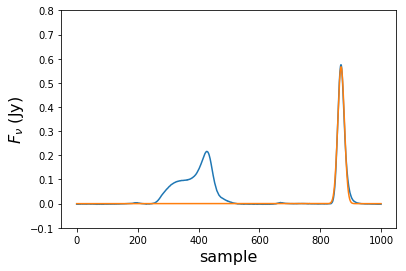

In [12]:
#mean_profile = np.load('mean_profile.npy')

#meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
#meanprof_Jy[meanprof_Jy < 0] = 0
##mean_value = (np.mean(mean_profile) / np.median(mean_profile) - 1) * 12.

##print("Mean pulse flux = %s Jy" % (mean_value))



#profile = inter.interp1d(x, meanprof_Jy, kind='linear')
#xnew = np.arange(0,x.size-1,(x.size-1.)/n)
#meanprof_inter = profile(xnew)

#plt.plot(meanprof_inter)
#plt.xlabel('sample', fontsize=16)
#plt.ylabel(r'$F_{\nu}$ (Jy)', fontsize=16)
##plt.xlim(0,1.6e-2)
#plt.ylim(-.1, 0.8)

mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
x = np.arange(1000)
popt, pcov = curve_fit(gaussian, x, meanprof_Jy, bounds=([0.,-np.inf,800.],[1.,np.inf,895.]))

plt.plot(meanprof_Jy)
plt.plot(x, gaussian(x, *popt))
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$F_{\nu}$ (Jy)', fontsize=16)
#plt.xlim(0,1.6e-2)
plt.ylim(-.1, 0.8)

Isolate the main pulse, sqrt it, and center

(-0.1, 0.8)

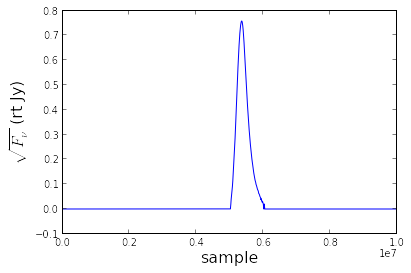

In [3]:
pulse_ref = meanprof_inter

for i in np.arange(meanprof_inter.size):
    if (float(i) < n*830./1000. or float(i) > n*940./1000.):
        pulse_ref[i] = 0

pulse_ref = np.sqrt(pulse_ref)
pulse_ref = np.roll(pulse_ref, -n/3)

plt.plot(pulse_ref)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$\sqrt{F_{\nu}}$ (rt Jy)', fontsize=16)
#plt.xlim(0,1.6e-2)
plt.ylim(-.1, 0.8)

Invent some sinusoidal wave at frequency of observed band

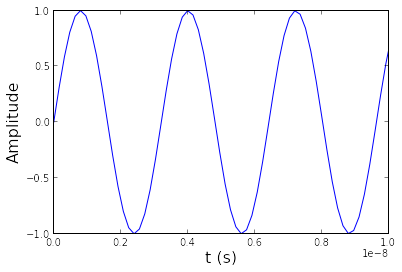

In [4]:
angular_freq = 2*np.pi*freq
t = np.linspace(0., p_spin, n)
phase_ref = np.sin(angular_freq*t)

plt.plot(t, phase_ref)
plt.xlim(0, 1e-8)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'Amplitude', fontsize=16)

Compute an electric field

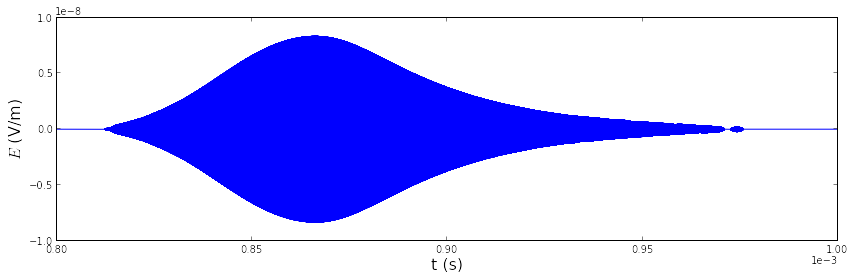

In [8]:
a = 109797  # rt(kg)*m/s^2/A; a = sqrt(2*16MHz/(c*n*epsilon_0)), conversion factor between
            # sqrt(Jansky) and E field strength assuming n=1 and a 16MHz bandwidth

b = 1e-13   # rt(kg)/s; a*b = 1.1e-8 V/m

E_field = a*b*pulse_ref*phase_ref

plt.figure(figsize=(14,4))
plt.plot(t, np.roll(E_field, (int)(1e-5/p_spin*n)))
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlim(0.8e-3,1e-3)
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)

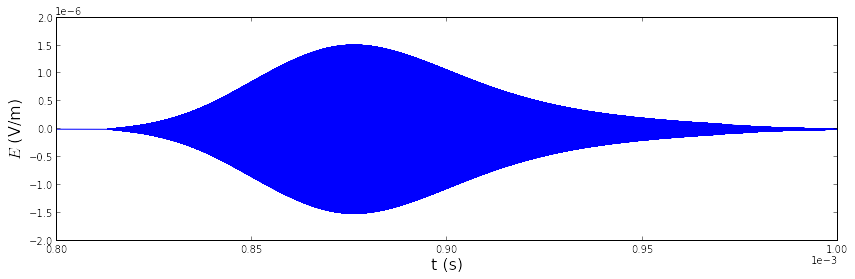

In [10]:
lim = (int)(np.sqrt(p_phase*2*R)*insample) # How far does tau_geom have to go to get to one period
lim *= 100

E_field = np.zeros(n)
E_tot = np.zeros(n)
pulse = np.zeros(n)
phase = np.zeros(n)
i = -lim

while (i < lim):
    #print i, tau_phase(i*p_spin/n)*n/p_spin, tau_group(i*p_spin/n)*n/p_spin
    phase = np.roll(phase_ref, (int)(tau_phase(i*intime)*insample))
    pulse = np.roll(pulse_ref, (int)(tau_group(i*intime)*insample))
    E_field = a*b*phase*pulse
    E_tot += E_field
    i+=lim/100

plt.figure(figsize=(14,4))
#plt.plot(t.reshape(-1,1e3).mean(axis=1), E_tot.reshape(-1,1e3).mean(axis=1)) # downsampling before plotting.
plt.plot(t, E_tot)
plt.xlim(0.8e-3,1.0e-3)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)